# preprocessing

## 1.0 Create tokenizer

In [11]:
from nltk.stem import SnowballStemmer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet

# def get_wordnet_pos(treebank_tag):
# 
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

# tokenize words
# remove stop words
# stemming
stop_words = set(stopwords.words('english'))
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer('english')
        self.tokenizer = RegexpTokenizer(r'\b[a-z]{2,}\b')
    def __call__(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)
        text = BeautifulSoup(text, "html.parser").get_text()
        tokens = [self.wnl.stem(x) for x in self.tokenizer.tokenize(text) if x not in stop_words]
        return tokens

tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
bow_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2.0 Word2Vec

In [12]:
from nltk import sent_tokenize
import time
import json
import glob
import os

# Read each JSONL file and append to the list
def create_sentences():
    for file in glob.glob('data/word2vec/*.jsonl'):

        print("Processing file: " + file)
        sentences = set()
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    data = json.loads(line)
                    if 'timestamp' in data and 'text' in data:
                        timestamp = pd.to_datetime(data['timestamp'], unit='ms')
                        if timestamp < pd.Timestamp('2019-01-01'):
                            sentences.update(set(sent_tokenize(data['text'])))
                except json.JSONDecodeError:
                    print(f"Skipping bad line in file {file}")
    
        with open('data/word2vec_processed/sentences.txt', 'a', encoding='utf-8') as f:
            for sentence in sentences:
                if len(sentence) > 2:
                    f.write(sentence + '\n')

if not os.path.exists('data/word2vec_processed/sentences.txt'):
    create_sentences()

Train Word2Vec model

In [26]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count
# Skip-gram model (sg = 1)
size = 200
window = 3
min_count = 20
print(f"number of cores: {cpu_count()}")
workers = cpu_count()
sg = 1
# ========= Train the Word2Vec model =========
word2vec_model_file =  'models/word2vec_' + str(size) + '.model'
print("Training Word2Vec Model")
start_time = time.time()

with open('data/word2vec_processed/sentences.txt', 'r', encoding='utf-8') as f1:
    with open('data/word2vec_processed/sentences_tokenized.txt', 'a', encoding='utf-8') as f2:
        for line in f1:
            tokens = LemmaTokenizer()(line)
            if len(tokens) > 0:
                f2.write(' '.join(tokens) + '\n')
            
# Train the Word2Vec Model
w2v_model = Word2Vec(corpus_file='data/word2vec_processed/sentences_tokenized.txt', 
                     min_count = min_count,
                     vector_size = size,
                     workers = workers, 
                     window = window, 
                     sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

number of cores: 20
Training Word2Vec Model


C:\Users\Utente\AppData\Local\Temp\ipykernel_10488\3035441472.py:42: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Time taken to train word2vec model: 81177.01556563377


Plot the word2vec model

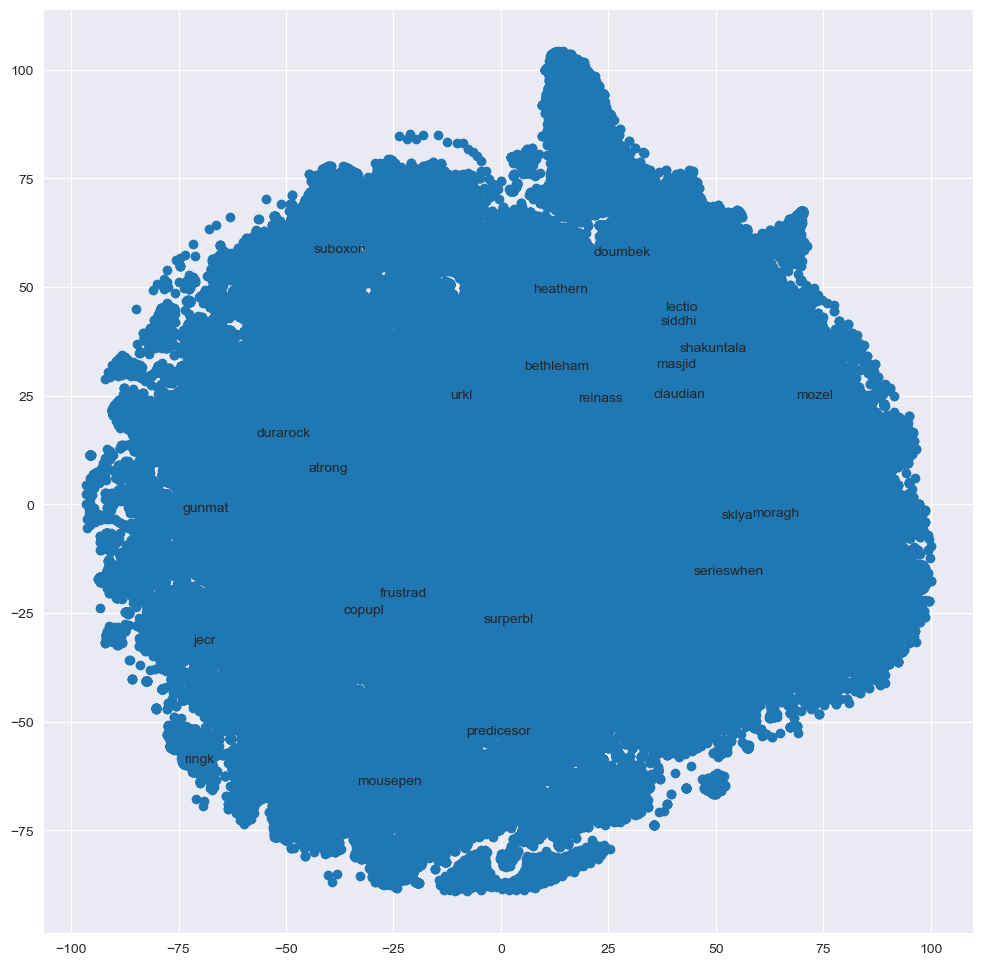

In [4]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np    
from gensim.models import Word2Vec

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

word2vec_model_file =  'models/word2vec_200.model'
model = Word2Vec.load(word2vec_model_file)
x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


import matplotlib.pyplot as plt
import random

random.seed(0)

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

#
# Label randomly subsampled 25 data points
#
indices = list(range(len(labels)))
selected_indices = random.sample(indices, 25)
for i in selected_indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
plt.show()

## 3.0 W2VLDA

In [33]:
import matplotlib.pyplot as plt


### Create embedding (both global and target domain)

In [30]:
domain_embedding =  'data/domain_embedding.txt'
print(model.vw['good'])
with open(domain_embedding, 'w+', encoding='utf-8') as f:
    for word in model.wv.index_to_key:
        f.write(f'{word},{",".join(map(str, model.wv[word]))}\n')


### Create brown clusters

In [32]:
from brown_clustering import BigramCorpus, BrownClustering
from nltk import sent_tokenize
import pandas as pd

df = pd.read_csv('data/amazon_reviews.txt', sep='\t')

reviews = df['REVIEW_TEXT'].tolist()
sentences = [sent_tokenize(review) for review in reviews]
flat_sentences = [LemmaTokenizer()(sentence) for sublist in sentences for sentence in sublist]
# remove empty sentences
flat_sentences = [sentence for sentence in flat_sentences if sentence]

# create a corpus
corpus = BigramCorpus(flat_sentences, alpha=0.4, min_count=10)
corpus.ranks()
# create a clustering
clustering = BrownClustering(corpus, m=500) # m is the number of clusters

# train the clustering
clusters = clustering.train()

100%|██████████| 21351/21351 [10:16<00:00, 34.65it/s]


In [33]:
print(*clusters, sep='\n')

['br']
['use']
['one']
['great']
['like']
['work']
['good']
['love']
['get']
['look']
['product']
['would']
['realli']
['well']
['time']
['qualiti']
['make']
['price']
['also']
['need']
['much']
['easi']
['recommend']
['nice']
['buy']
['littl']
['bought']
['want']
['go']
['even']
['fit']
['purchas']
['tri']
['got']
['thing']
['set']
['light']
['made']
['year']
['day']
['back']
['watch']
['take']
['better']
['first']
['size']
['put']
['bag']
['come']
['lot']
['perfect']
['still']
['way']
['feel']
['see']
['think']
['could']
['color']
['game']
['two']
['play']
['small']
['keep']
['best']
['sound']
['review']
['seem']
['order']
['help']
['new']
['book']
['long']
['know']
['give']
['say']
['right']
['differ']
['problem']
['expect']
['case']
['last']
['find']
['batteri']
['bit']
['tv']
['enough']
['old']
['pretti']
['mani']
['around']
['read']
['sinc']
['amazon']
['happi']
['hold']
['someth']
['month']
['wear']
['pictur']
['without']
['far']
['anoth']
['item']
['everi']
['start']
['comfort'

In [20]:
import json
codes = clustering.codes()

with open('data/brown-clusters.txt', 'w') as file:
    for key, value in codes.items():
        file.write(f'{value} {key}\n')

### Find topics with LDA

In [3]:
lda

NameError: name 'lda' is not defined

### Combine all in W2VLDA

In [4]:
asdasd

NameError: name 'asdasd' is not defined